# Transfer Learning(전이 학습)

Transfer Learning(전이 학습)이란 기존에 만들어진 모델과, 그 모델이 학습한 weights를 그대로 가져와 일부 Layer를 추가하여 학습하는 방법이다. 여기서 사전에 학습이 완료된, 이미지 분류에 최적화 된 weights를 포함하는 모델을 Pre-Trained Model이라고 한다. 우리는 이 Pre-Trained Model을 이용하여 아주 쉽게 이미지 분류 문제를 해결할 수 있다.

진행 순서는 다음과 같다
1. Trianing 및 Test Datasets을 불러오고 정규화
2. 모델을 정의 -> 여기서 Pre-trained model을 사용
3. Loss function과 Optimizer를 정의
4. Training 데이터를 사용하여 신경망을 학습
5. Test Data를 사용하여 신경망이 잘 훈련했는지 검사

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [14]:
# 학습을 위한 데이터 증가(Augmentation)와 일반화하기
# 단지 검증을 위한 일반화하기
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'

# path['train']은 train set의 경로
# path['val']은 val set의 경로
# join은 문자열을 이어 붙여주는 함수

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = { 'train' : torch.utils.data.DataLoader(image_datasets['train'], batch_size=4,
                                             shuffle=True, num_workers=0),
                'val' : torch.utils.data.DataLoader(image_datasets['val'], batch_size=4,
                                             shuffle=True, num_workers=0) }

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
#dataset_sizes['train'] = train set 사진 갯수
#dataset_sizes['val'] = val set 사진 갯수

class_names = image_datasets['train'].classes
#class_names = ['ants', 'bees']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device) #GPU가 이용 가능한지를 확인

cuda:0


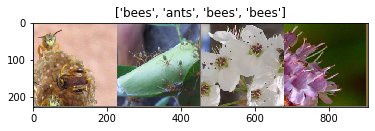

In [17]:
def imshow(inp, title = None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.005)

# 한개의 배치(batch)만큼 이미지를 불러온다. 배치 사이즈를 4로 했으니 사진 4장이 로드된다.
inputs, classes = next(iter(dataloaders['train']))

# 로드된 데이터에 make_grid 함수를 통해 그리드를 추가한다.
out = torchvision.utils.make_grid(inputs)

# 이미지를 출력한다.
imshow(out, title=[class_names[x] for x in classes])

1. Pretrained Model을 가져온다. ResNet18을 사용
2. model_ft.fc.in_features는 ResNet18모델의 마지막 단에서, 출력 노드의 갯수를 구해주는 함수
3. Pretrained-model의 끝단에 Fully connected layer를 추가로 삽입하고 노드를 연결시켜 주는 것이 우리가 사용할 모델

*이 때, Fully connected layer 즉 Linear layer의 출력 노드 갯수는 Class의 갯수와 같아야한다.

본 예제는 개미와 벌로 이루어진 2 Class classification이므로, 출력 노드 갯수는 2가 된다.

In [18]:
model_ft = models.resnet18(pretrained=True) 
num_ftrs = model_ft.fc.in_features 
model_ft.fc = nn.Linear(num_ftrs, 2) 

model_ft = model_ft.to(device)

In [19]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## SGD의 경우, 기존의 Gradient Descent와 비교해서 크게 두 가지의 장점이 있다.

1. 첫 번째로는 GD를 사용하는 경우, weight update를 진행 할 때 전체 데이터에 대해 Loss 함수를 계산해야 하지만, SGD의 경우 전체 데이터 대신 일부 데이터의 모음(mini batch)에 대해서만 Loss 함수를 계산한다.

2. 두 번째로는 SGD의 경우 최적점으로 이동하는 과정에서 Momentum이라는 성질을 이용하게 된다. 앞서 말했던 것처럼, SGD는 일부 데이터의 모음(mini batch)에 대해서만 loss 함수를 계산하고 그 기울기를 weight update에 사용하기 때문에, Learning rate가 작다 하더라도 update되는 weight가 매우 noisy하다. 따라서 Momentum이라는 개념을 추가하여, update 되는 weight의 비율을 상대적으로 더 줄임으로써 일부 데이터의 모음만을 가지고 안정적으로 weight update를 하는 방법이다.

In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time() #시작 시간을 기록(총 소요 시간 계산을 위해)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1)) #epoch를 카운트
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:  #train mode와 validation mode 순으로 진행
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]: #dataloader로부터 dataset과 그에 해당되는 label을 불러옴
                inputs = inputs.to(device) #GPU로 입력데이터를 올림
                labels = labels.to(device) #GPU로 label을 올림

                # zero the parameter gradients
                optimizer.zero_grad() #Gradient를 0으로 초기화

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) #마지막 layer에서 가장 값이 큰 1개의 class를 예측 값으로 지정
                    loss = criterion(outputs, labels) 

                    # backward + optimize only if in training phase
                    if phase == 'train': # training 모드에서는 weight를 update한다.
                        loss.backward() #backward
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [21]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6528 Acc: 0.6844
val Loss: 0.2419 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.4928 Acc: 0.7664
val Loss: 0.2351 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.5742 Acc: 0.7869
val Loss: 0.3879 Acc: 0.8693

Epoch 3/24
----------
train Loss: 0.6012 Acc: 0.7787
val Loss: 0.3413 Acc: 0.8497

Epoch 4/24
----------
train Loss: 0.5769 Acc: 0.7828
val Loss: 0.5088 Acc: 0.8301

Epoch 5/24
----------
train Loss: 0.4703 Acc: 0.7992
val Loss: 0.2724 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.5369 Acc: 0.8033
val Loss: 0.8345 Acc: 0.7974

Epoch 7/24
----------
train Loss: 0.6471 Acc: 0.8197
val Loss: 0.2803 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3023 Acc: 0.8811
val Loss: 0.2089 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3365 Acc: 0.8730
val Loss: 0.2899 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.2952 Acc: 0.8852
val Loss: 0.3227 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.3802 Acc: 0.8443
val Loss: 0.2649 Acc: 0.9085

Ep

In [24]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

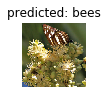

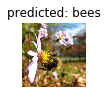

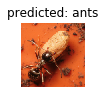

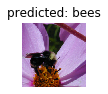

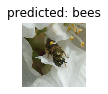

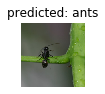

In [26]:
visualize_model(model_ft)